## Bayesian mixture

# Intuition

**FIGURE PLACEHOLDER:** ![Bayesian mixture](image_placeholder)

# Notation


## Mixture

A mixture model is a statistical model that represents the data as coming from a mixture of two or more underlying distributions. These models are particularly useful when the data may be generated by different processes or subgroups, but we don't have direct information about which subgroup each data point belongs to. In a mixture model, we assume that the observed data are generated from a weighted sum of these different distributions, where each distribution corresponds to a different "component" in the mixture. The probability density function (PDF) of a mixture model can be written as:

$$
f(y_i) = \sum_{k=1}^{K} \pi_k f_k(y_i)
$$

Where:
- $f(y_i)$ is the overall probability density function of the data point $y_i$.
- $K$ is the number of components (distributions) in the mixture (e.g., two populations in our height example).
- $\pi_k$ is the **mixture weight** for the $k$-th component, which represents the proportion of data points from that component in the total population. These weights satisfy the condition:

$$
\sum_{k=1}^{K} \pi_k = 1
$$

- $f_k(y_i)$ is the probability density function of the $k$-th component distribution, which can be any distribution, such as normal, exponential, etc.

In the case of a **mixture of normal distributions**, the individual components can be described by normal distributions with means $\mu_k$ and variances $\sigma_k^2$. The overall mixture density is then:

$$
f(y_i) = \sum_{k=1}^{K} \pi_k \mathcal{N}(y_i | \mu_k, \sigma_k^2)
$$

Where:
- $\mathcal{N}(y_i | \mu_k, \sigma_k^2)$ is the probability density function of the normal distribution for the $k$-th component, with mean $\mu_k$ and variance $\sigma_k^2$.


# Example

## Description

In [14]:
rm(list=ls())
set.seed(102)  # For reproducibility

# --- 1. Simulate Genotypes for Two Populations ---
N1 <- 100  # Number of individuals in Pop1
N2 <- 500  # Number of individuals in Pop2
M <- 3     # Number of SNPs (variants)

# Simulate genotype matrices (0, 1, 2 values for each SNP)
X_raw1 <- matrix(sample(0:2, N1 * M, replace = TRUE), nrow = N1, ncol = M)
X_raw2 <- matrix(sample(0:2, N2 * M, replace = TRUE), nrow = N2, ncol = M)

# Adding row and column names
rownames(X_raw1) <- paste("Pop1_Individual", 1:N1)
rownames(X_raw2) <- paste("Pop2_Individual", 1:N2)
colnames(X_raw1) <- colnames(X_raw2) <- paste("SNP", 1:M)

# Standardize genotype matrix (mean = 0, sd = 1 for each SNP)
X1 <- scale(X_raw1, scale = TRUE)
X2 <- scale(X_raw2, scale = TRUE)


In [15]:
# --- 2. Simulate Traits (Height) for Two Populations ---
# True SNP effects
beta_true_pop1 <- matrix(c(0.1, 0.0, 0.0), nrow = M, ncol = 1)  # SNP2 has no effect in Pop1
beta_true_pop2 <- matrix(c(0.1, 0.2, 0.0), nrow = M, ncol = 1)  # SNP2 has effect in Pop2

# Residual variance (same for both populations)
Sigma_e <- matrix(c(1.0), nrow = 1)

# Generate traits: Y = X * B + E (height)
Y1 <- X1 %*% beta_true_pop1 + rnorm(N1)
Y2 <- X2 %*% beta_true_pop2 + rnorm(N2)

# Combine the populations into one data frame
X_combined <- rbind(X1, X2)
Y_combined <- c(Y1, Y2)

# Standardize the traits (height) for both populations
Y_combined <- scale(Y_combined)


In [16]:
# --- 3. Model Effect Sizes for SNP2 in Both Populations ---
# For simplicity, we assume that effect size estimation is done through linear regression
# For Pop1, SNP2 has no effect (beta = 0)
# For Pop2, SNP2 has a positive effect (beta > 0)

# Fit a linear model for Pop1 and Pop2
model_pop1 <- lm(Y1 ~ X_raw1[, 2])  # SNP2 has no effect
model_pop2 <- lm(Y2 ~ X_raw2[, 2])  # SNP2 has a positive effect

# Get the effect sizes (betas)
beta_pop1 <- coef(model_pop1)[2]  # Effect size of SNP2 in Pop1
beta_pop2 <- coef(model_pop2)[2]  # Effect size of SNP2 in Pop2

# Print the effect sizes
cat("Effect size for SNP2 in Pop1: ", beta_pop1, "\n")
cat("Effect size for SNP2 in Pop2: ", beta_pop2, "\n")


Effect size for SNP2 in Pop1:  -0.007516277 
Effect size for SNP2 in Pop2:  0.1633263 


In [17]:
# --- 4. Mixture Model for Estimating the Overall Effect Size of SNP2 ---
# We combine the two populations and assume a mixture distribution for the effect size
pop1_weight <- N1 / (N1 + N2)
pop2_weight <- N2 / (N1 + N2)

# Mixture distribution for SNP2 effect size
mixture_effect_size <- pop1_weight * beta_pop1 + pop2_weight * beta_pop2

cat("Mixture model estimate for SNP2 effect size: ", mixture_effect_size, "\n")



Mixture model estimate for SNP2 effect size:  0.1348525 


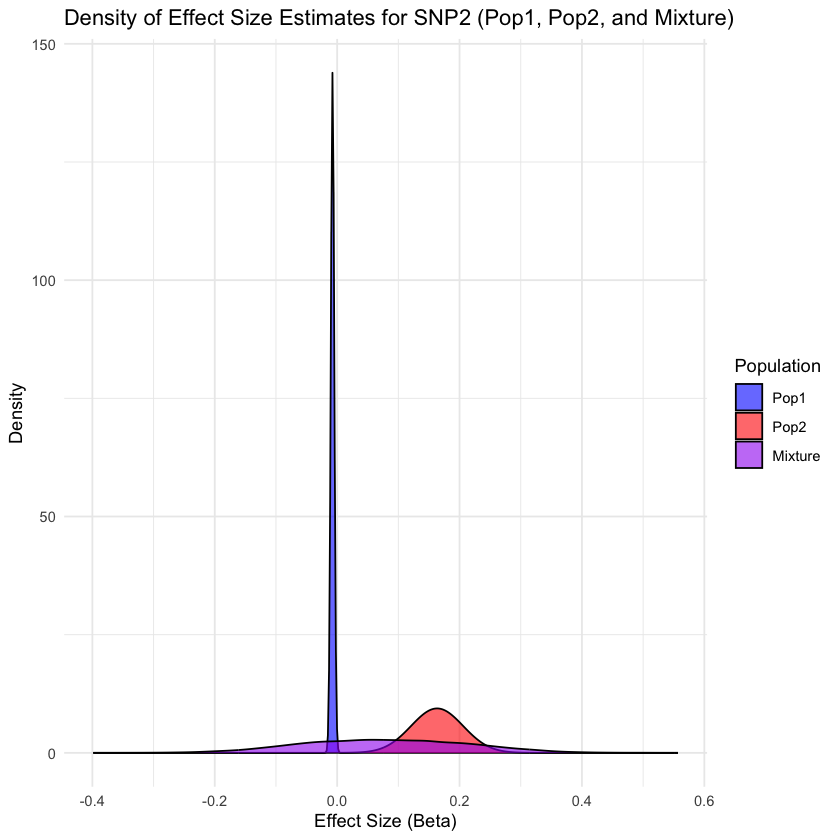

In [18]:
# --- 5. Visualization ---
library(ggplot2)

# Generate a data frame to store the betas for each population
beta_data <- data.frame(
  Beta = c(rep(beta_pop1, N1), rep(beta_pop2, N2)),
  Population = factor(c(rep("Pop1", N1), rep("Pop2", N2)))
)

# Generate the mixture distribution (weighted average of the two effect sizes)
mixture_data <- data.frame(
  Beta = c(rnorm(10000, mean = beta_pop1, sd = 0.1), rnorm(10000, mean = beta_pop2, sd = 0.1)),
  Population = rep("Mixture", 20000)
)

# Combine the data
combined_beta_data <- rbind(beta_data, mixture_data)

# Plot the density of beta estimates for Pop1, Pop2, and the mixture
ggplot(combined_beta_data, aes(x = Beta, fill = Population)) +
  geom_density(alpha = 0.6) +
  labs(title = "Density of Effect Size Estimates for SNP2 (Pop1, Pop2, and Mixture)",
       x = "Effect Size (Beta)", y = "Density", fill = "Population") +
  theme_minimal() +
  scale_fill_manual(values = c("blue", "red", "purple"))
